<a href="https://colab.research.google.com/github/fredtush/Dating-App-Recommender/blob/main/P5_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pata Mchumba Dating App Recommender

### Group Members

1. Elsie Kiprop
2. Iain Mosima
3. Benson Muriu
4. Fred Mutuma
5. Oscar Karuga
6. Peter Kigotho





## 1.1 Business Understanding.
With the current generation embracing technology and its applications, many people have become accustomed to the idea of using dating apps. Therefore, Pata Mchumba,  a dating company, has approached us to create a recommendation system for their users to increase the effectiveness of matches based on their preferences. Moreover our recommender will focus mainly on emotional connection rather than superficial love.

## 1.2 Objectives
### Main Objective:
To build a dating app recommender system that successfully maximises the matches.
### Specific Objectives
1. To create a recommender system that is not based on ratings.

2. To determine the most common traits among users.

3. Use descriptive essays as a matching factor.
4. Ensure every profile is treated as a complete profile. 

## 1.3 Data Understanding
Our data was sourced from [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2015.11889737). We considered the ethical concerns and no rights were infringed in the collection of this data as OKCupid provided this data for use by the public.
The data contained 31 columns and 59964 columns.

## 1.4 Metrics for success
Our metric of success will be determined by how accurately the recommender successfully matches individuals. Apps such as tinder have about 60% correctness  for men and 10 % for women. Our recommender system aims to find a higher percentage than this.

##1.5 Importing Libraries

In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np


try:
  from tabulate import tabulate
except:
  !pip install tabulate
finally:
  from tabulate import tabulate



try:
  import gensim
except:
  !pip install gensim
  !pip install python_levenshtein
finally:
  import gensim
  from gensim.models import Word2Vec

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# setting font size for all plots
font = {'size'   : 16}

plt.rc('font', **font)

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.5.1 Reading the Data

In [ ]:
#Importing dataset

dating_df = pd.read_csv('/content/drive/MyDrive/okcupid_profiles.csv')

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
#First 2 rows of the data set
dating_df.head(2)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN


###1.5.2 Checking the Data
In this section we will check for the shape of the data, number of unique vales and the number of missing values per column.

In [ ]:
#Checking for the shape of the data
print("Number of rows:", dating_df.shape[0])
print("Number of columns:", dating_df.shape[1],'\n')

Number of rows: 59946
Number of columns: 31 



The dataset has 59946 rows and 31 columns

In [ ]:
# Loop to check for missing values and unique values per column 
data_info = []
for i, column in enumerate(dating_df.columns):
    data_info.append([column, len(pd.unique(dating_df[column].values)), np.sum(pd.isnull(dating_df[column]))])

print(tabulate(data_info, headers=['Feature','No of unique values', 'No of null values']),"\n")   

Feature        No of unique values    No of null values
-----------  ---------------------  -------------------
age                             54                    0
status                           5                    0
sex                              2                    0
orientation                      3                    0
body_type                       13                 5296
diet                            19                24395
drinks                           7                 2985
drugs                            4                14080
education                       33                 6628
ethnicity                      218                 5680
height                          61                    3
income                          13                    0
job                             22                 8198
last_online                  30123                    0
location                       199                    0
offspring                       16              

The table above shows missing values per column and unique values per column. A number of columns have quite a huge number of missing values that we will deal with eventually in the notebook.

##1.6 Data Cleaning
In this section we will clean our data. This includes dealing with missing values. Natuaral Language processing will also be done to aid in cleaning text data in the essays columns. The columns that will not be required will not be used shall be dropped.

###1.6.1 Checking null values percentage

In [ ]:
#Checking for the percentage of null values per column.
dating_df.isna().sum()/len(dating_df)*100

age             0.000000
status          0.000000
sex             0.000000
orientation     0.000000
body_type       8.834618
diet           40.694959
drinks          4.979482
drugs          23.487806
education      11.056618
ethnicity       9.475194
height          0.005005
income          0.000000
job            13.675641
last_online     0.000000
location        0.000000
offspring      59.321723
pets           33.231575
religion       33.740366
sign           18.443266
smokes          9.194942
speaks          0.083408
essay0          9.154906
essay1         12.631368
essay2         16.077803
essay3         19.143896
essay4         17.577486
essay5         18.099623
essay6         22.972342
essay7         20.770360
essay8         32.070530
essay9         21.023922
dtype: float64

Most of our columns seem to have the problem of missing data and that will be addressed in these subsequent cells. The `offspring` column is see to have the highest number of missing values at 59.3%.

###1.6.2 Checking datatypes

In [ ]:
#Checking the data type for each column
dating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   status       59946 non-null  object 
 2   sex          59946 non-null  object 
 3   orientation  59946 non-null  object 
 4   body_type    54650 non-null  object 
 5   diet         35551 non-null  object 
 6   drinks       56961 non-null  object 
 7   drugs        45866 non-null  object 
 8   education    53318 non-null  object 
 9   ethnicity    54266 non-null  object 
 10  height       59943 non-null  float64
 11  income       59946 non-null  int64  
 12  job          51748 non-null  object 
 13  last_online  59946 non-null  object 
 14  location     59946 non-null  object 
 15  offspring    24385 non-null  object 
 16  pets         40025 non-null  object 
 17  religion     39720 non-null  object 
 18  sign         48890 non-null  object 
 19  smok

In [ ]:
# checking for abnormality in the numerical columns
dating_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,59946.0,32.340290,9.452779,18.0,26.0,30.0,37.0,110.0
height,59943.0,68.295281,3.994803,1.0,66.0,68.0,71.0,95.0
income,59946.0,20033.222534,97346.192104,-1.0,-1.0,-1.0,-1.0,1000000.0


###1.6.2 The Body Type Column

In [ ]:
#check value count of body type
dating_df['body_type'].value_counts()

average           14652
fit               12711
athletic          11819
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: body_type, dtype: int64

For this column we will fill the missing values using with `unspecified` since a user may have skipped the section to fill in information on their body type.

In [ ]:
#Replacing the missing values with unspecified.
dating_df['body_type'].fillna('Unspecified',inplace=True)

###1.6.3 The Diet Column


In [ ]:
#check value count of diet
dating_df['diet'].value_counts()

mostly anything        16585
anything                6183
strictly anything       5113
mostly vegetarian       3444
mostly other            1007
strictly vegetarian      875
vegetarian               667
strictly other           452
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly halal            18
strictly kosher           18
halal                     11
kosher                    11
Name: diet, dtype: int64

It is evident that most of the users do not have diet restrictions.
For this column we noticed that some of the option are similar therefore we will replace similar classes with the same class. 

In [ ]:
dating_df['diet'] = dating_df['diet'].replace(['mostly anything','strictly anything'],'anything')
dating_df['diet'] = dating_df['diet'].replace(['mostly vegetarian','strictly vegetarian','mostly vegan','strictly vegan','vegan'],'vegetarian')
dating_df['diet'] = dating_df['diet'].replace(['mostly halal','strictly halal'],'halal')
dating_df['diet'] = dating_df['diet'].replace(['mostly kosher','strictly kosher'],'kosher')
dating_df['diet'] = dating_df['diet'].replace(['mostly other','strictly other'],'other')

dating_df['diet'].fillna('Unspecified',inplace=True)

###1.6.4 The Drinks Column

The missing values in the drinks column will be replaced with unspecified since some users may choose not to disclose that information.

In [ ]:
#check value count of drinks
dating_df['drinks'].value_counts()

socially       41780
rarely          5957
often           5164
not at all      3267
very often       471
desperately      322
Name: drinks, dtype: int64

We will then go ahead and group the users under the drinks column into 3 categories.Those who drink will be under category 1. Those who did not disclose that information will be under category 2. Those who do not drink will be under category 0.

In [ ]:
#Filling null values with unpecified.
dating_df['drinks'].fillna('Unspecified',inplace=True)

In [ ]:
#Checking for the number of users per category.
dating_df.drinks.value_counts()

socially       41780
rarely          5957
often           5164
not at all      3267
Unspecified     2985
very often       471
desperately      322
Name: drinks, dtype: int64

In [ ]:
#Grouping the drinkers
def drinker(value):
    if value == 'socially' or value == 'often' or value == 'very often' or value == 'rarely' or value == 'desperately':
        return 1
    elif value == 'not at all':
      return 0
    else:
      return 2

In [ ]:
dating_df['drinks2'] = dating_df.drinks.apply(lambda x: drinker(x))
dating_df['drinks2'].value_counts()

1    53694
0     3267
2     2985
Name: drinks2, dtype: int64

We can see that the majority of these people drink.

###1.6.5 The Drugs Column
Similar to the drinks column we will replace the null values with unspecified as some users chose not to put that information public. We will also go ahead to group the users into 3 categories.
Those who use drugs in category 1, those who do not abuse drugs in category 0 and those who have not disclosed that information in category 2.

In [ ]:
#check value count of drinks
dating_df['drugs'].value_counts()

never        37724
sometimes     7732
often          410
Name: drugs, dtype: int64

In [ ]:
#Replacing the null values with unspecified.
dating_df['drugs'].fillna('Unspecified',inplace=True)

In [ ]:
#Grouping 
def drugs(value):
    if value == 'often' or value == 'sometimes':
        return 1
    elif value == 'never':    
      return 0
      
    return 2

In [ ]:
dating_df['drugs2'] = dating_df.drugs.apply(lambda x: drugs(x))
dating_df['drugs2'].value_counts()

0    37724
2    14080
1     8142
Name: drugs2, dtype: int64

From the above, majority have never used drugs.

###1.6.6 The Education Column

In [ ]:
dating_df['education'].value_counts()

graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

We can see that majority have graduated from college or university.

In [ ]:
#Replacing the null values with unspecified because one may have not provided that information.
dating_df['education'].fillna('Unspecified',inplace=True)

###1.6.7 The Ethnicity Column

In [ ]:
#Checking for number of users per race.
dating_df['ethnicity'].value_counts()

white                                                                 32831
asian                                                                  6134
hispanic / latin                                                       2823
black                                                                  2008
other                                                                  1706
                                                                      ...  
middle eastern, indian, white                                             1
asian, middle eastern, black, white, other                                1
asian, middle eastern, indian, hispanic / latin, white, other             1
black, native american, indian, pacific islander, hispanic / latin        1
asian, black, indian                                                      1
Name: ethnicity, Length: 217, dtype: int64

Majority of the users are white while a monority represent a combination of different ethnic groups.

In [ ]:
dating_df['ethnicity'].fillna('Unspecified',inplace=True)

###1.6.7 The Height Column

In [ ]:
# dropping null values in height 
# since there are only 0.005% are missing 

dating_df.dropna( subset=['height'],inplace=True)

###1.6.8 The Job Column

In [ ]:
dating_df['job'].value_counts()

other                                7589
student                              4882
science / tech / engineering         4848
computer / hardware / software       4709
artistic / musical / writer          4438
sales / marketing / biz dev          4391
medicine / health                    3680
education / academia                 3513
executive / management               2373
banking / financial / real estate    2266
entertainment / media                2250
law / legal services                 1381
hospitality / travel                 1364
construction / craftsmanship         1021
clerical / administrative             805
political / government                708
rather not say                        436
transportation                        366
unemployed                            273
retired                               250
military                              204
Name: job, dtype: int64

In [ ]:
#Filling the null values with unspecified.
dating_df['job'].fillna('Unspecified',inplace=True)

Most people filled the job section with other. The unemployed people are 273. The military career has the least number of users at 204. 436 of these users chose not to disclose their jobs. For the missing values we will replace them with `unspecified` since some users may have chosen to skip that section.

###1.6.9 The Offspring Column
This column shows whether one has children or if one wishes to have kids in the future or not.


In [ ]:
#Checking the number of each unique value in the offsprings column
dating_df['offspring'].value_counts()

doesn't have kids                          7559
doesn't have kids, but might want them     3875
doesn't have kids, but wants them          3565
doesn't want kids                          2927
has kids                                   1883
has a kid                                  1881
doesn't have kids, and doesn't want any    1132
has kids, but doesn't want more             442
has a kid, but doesn't want more            275
has a kid, and might want more              231
wants kids                                  225
might want kids                             182
has kids, and might want more               115
has a kid, and wants more                    71
has kids, and wants more                     21
Name: offspring, dtype: int64

In [ ]:
#Replacing the null values with unspecified
dating_df['offspring'].fillna('Unspecified',inplace=True)

###1.6.10 The Religion Column
This column represents the different religions that the dating site users belong to.

In [ ]:
#Checking number of each unique value in the the religion column
dating_df['religion'].value_counts()

agnosticism                                   2724
other                                         2691
agnosticism but not too serious about it      2636
agnosticism and laughing about it             2496
catholicism but not too serious about it      2318
atheism                                       2175
other and laughing about it                   2119
atheism and laughing about it                 2074
christianity                                  1957
christianity but not too serious about it     1952
other but not too serious about it            1554
judaism but not too serious about it          1517
atheism but not too serious about it          1318
catholicism                                   1064
christianity and somewhat serious about it     927
atheism and somewhat serious about it          848
other and somewhat serious about it            846
catholicism and laughing about it              726
judaism and laughing about it                  681
buddhism but not too serious ab

#### Creating a religion serious column
This section deals with replacing the null values in the religion column with `unspecified` and classifying the religions into those who are serious and those who arent serious with religion. Those that are serious will be under class 1. Those that arent serious will be represented with 0 and those who have not discoled their religion will be represented by 2

In [ ]:
#Replacing null values with unspecified
dating_df['religion'].fillna('Unspecified',inplace=True)

In [ ]:
def religion_serious(value):
   # checking if a user is serious with his/her religion
    if value.__contains__('not') or value.__contains__('laughing'):
        return 0
    elif value.__contains__('Unspecified'):
        return 2
        
    return 1

In [ ]:
dating_df['religionSerious'] = dating_df.religion.copy().astype(str).apply(lambda x: religion_serious(x))
dating_df['religionSerious'].value_counts()

0    21207
2    20223
1    18513
Name: religionSerious, dtype: int64

In [ ]:
# checking if the religion_serious function worked
dating_df[['religionSerious','religion']].sample(30)

,religionSerious,religion
42092,2,Unspecified
43744,2,Unspecified
8366,0,agnosticism and laughing about it
27203,0,catholicism and laughing about it
21357,0,agnosticism and laughing about it
30183,2,Unspecified
13521,2,Unspecified
18553,1,other
35027,0,christianity but not too serious about it
13572,1,atheism


**Creating a religion only column**



In [ ]:
def religion(value):
    # splitting the column and extracting the first string
    religion = value.split(' ')[0]
    return religion

In [ ]:
dating_df.religion = dating_df.religion.astype(str).apply(lambda x: religion(x))
dating_df.religion[:10]

0     agnosticism
1     agnosticism
2     Unspecified
3     Unspecified
4     Unspecified
5         atheism
6     Unspecified
7    christianity
8    christianity
9         atheism
Name: religion, dtype: object

In [ ]:
# checking the value counts 
dating_df.religion.value_counts()

Unspecified     20223
agnosticism      8812
other            7743
atheism          6985
christianity     5787
catholicism      4758
judaism          3098
buddhism         1948
hinduism          450
islam             139
Name: religion, dtype: int64

###1.6.11 The Zodiac Column
To deal with the missing values in this section, we will fill the missing values with uninterested as zodiac signs do not matter to some people.
We will further clean the column and only pick out the zodiac sign and remove the rest of the text in each row.

In [ ]:
dating_df['sign'].value_counts()

gemini and it&rsquo;s fun to think about         1782
scorpio and it&rsquo;s fun to think about        1772
leo and it&rsquo;s fun to think about            1692
libra and it&rsquo;s fun to think about          1649
taurus and it&rsquo;s fun to think about         1640
cancer and it&rsquo;s fun to think about         1597
pisces and it&rsquo;s fun to think about         1592
sagittarius and it&rsquo;s fun to think about    1583
virgo and it&rsquo;s fun to think about          1574
aries and it&rsquo;s fun to think about          1573
aquarius and it&rsquo;s fun to think about       1503
virgo but it doesn&rsquo;t matter                1497
leo but it doesn&rsquo;t matter                  1457
cancer but it doesn&rsquo;t matter               1454
gemini but it doesn&rsquo;t matter               1453
taurus but it doesn&rsquo;t matter               1450
libra but it doesn&rsquo;t matter                1408
aquarius but it doesn&rsquo;t matter             1408
capricorn and it&rsquo;s fun

**Creating a sign serious column**

In [ ]:
#Replacing the missing values with uninterested.
dating_df['sign'].fillna('Uninterested',inplace=True)

In [ ]:
def sign_serious(value):
   # checking if a user is serious with his/her religion
    if value.__contains__('doesn&rsquo;t'):
        return 0
    elif value.__contains__('it&rsquo;s'):
        return 1
        
    return 2

In [ ]:
dating_df['signSerious'] = dating_df.sign.copy().astype(str).apply(lambda x: sign_serious(x))
dating_df['signSerious'].value_counts()

2    23852
1    19333
0    16758
Name: signSerious, dtype: int64

In [ ]:
# checking if the religion_serious function worked
dating_df[['signSerious','sign']].sample(30)

,signSerious,sign
14624,2,Uninterested
19055,1,taurus and it&rsquo;s fun to think about
46334,2,Uninterested
8918,1,gemini and it&rsquo;s fun to think about
46582,1,virgo and it&rsquo;s fun to think about
33677,0,cancer but it doesn&rsquo;t matter
29931,0,sagittarius but it doesn&rsquo;t matter
22299,2,Uninterested
8762,2,Uninterested
39380,2,taurus


**Creating a zodiac only column**

In [ ]:
# doing the same thing as in the religion function
def zodiac_sign(value):
    zodiac = value.split(' ')[0]
    return zodiac

In [ ]:
dating_df.sign = dating_df.sign.astype(str).apply(lambda x: zodiac_sign(x))
dating_df.sign[:10]

0         gemini
1         cancer
2         pisces
3         pisces
4       aquarius
5         taurus
6          virgo
7    sagittarius
8         gemini
9         cancer
Name: sign, dtype: object

###1.6.12 The Smokes Column

In [ ]:
# checking the value counts
dating_df['smokes'].value_counts()

no                43895
sometimes          3787
when drinking      3040
yes                2231
trying to quit     1480
Name: smokes, dtype: int64

We can see that majority do not smoke. To deal with the missing values we will replace then with `unspecified` as some of the users may choose not to disclose this information.

In [ ]:
# Fill null values with unspecified
dating_df['smokes'].fillna('Unspecified',inplace=True)

We will then go ahead and group the users. Those who smoke shall all be put in category 1. Those who do not smoke shall be put in category 0 while those who did not reveal that information will be put in category 2.

In [ ]:
def smoker(value):
    if value == 'sometimes' or value == 'when drinking' or value == 'yes' or value == 'trying to quit' :
        return 1
    elif value=='no':
        return 0
    else:
        return 2

In [ ]:
dating_df['smokes2'] = dating_df.smokes.apply(lambda x: smoker(x))
dating_df['smokes2'].value_counts()

0    43895
1    10538
2     5510
Name: smokes2, dtype: int64

###1.6.13 The Speaks Column
This column highlights the languages a users speaks.


In [ ]:
# Checking the value counts 
dating_df['speaks'].value_counts()

english                                                                21827
english (fluently)                                                      6627
english (fluently), spanish (poorly)                                    2059
english (fluently), spanish (okay)                                      1917
english (fluently), spanish (fluently)                                  1288
                                                                       ...  
english (fluently), urdu (poorly), japanese (poorly), french (okay)        1
english, spanish, hindi, c++                                               1
english (fluently), japanese (okay), thai (okay), chinese (poorly)         1
english (fluently), french (okay), italian (okay), hebrew (okay)           1
english (fluently), french, farsi                                          1
Name: speaks, Length: 7647, dtype: int64

Majority of the people speak english. The others speak english with an addition to other languages.

In [ ]:
# filling null values with unspecified
dating_df['speaks'].fillna('Unspecified',inplace=True)

###1.6.14 Dropping columns

Since we are considering an emotional match recommender system we won't consider height,job and income to prevent the recommender system from being biased. Since almost all users speak English, we will also drop that column. We will also drop the last_online column 

In [ ]:
def column_dropper(df):
    return df.drop(columns=['ethnicity', 'height', 'income', 'job', 'offspring', 'speaks', 'last_online'])

In [ ]:
# Dropping features not to be utilized by the recommendation engine
dating_df = column_dropper(dating_df)

###1.6.15 Filtering out the data
In this section we will  retain only the single and available people and drop the people who are married.

In [ ]:
# keep only available people in the recommendation database 
dating_df = dating_df[dating_df.status.isin(['single', 'available'])].drop(columns='status')

###1.6.16 The Location Column

In [ ]:
dating_df['location'].value_counts()

san francisco, california    29919
oakland, california           6886
berkeley, california          3977
san mateo, california         1291
palo alto, california         1013
                             ...  
sunnyvale, california            1
islip terrace, new york          1
boise, idaho                     1
peoria, illinois                 1
rochester, michigan              1
Name: location, Length: 193, dtype: int64

We will filter this column and only pick the name of each state.

In [ ]:
# taking the state only from the location column
def state_getter(string):
    return string.split(',')[1]

dating_df['state'] = dating_df.location.apply(lambda x: state_getter(x))
# printing total states
print('Number of states:', len(dating_df['state'].unique()))
dating_df.state.value_counts()[:10]

Number of states: 38


 california              57473
 new york                   16
 illinois                    8
 texas                       4
 oregon                      4
 massachusetts               4
 michigan                    4
 arizona                     3
 florida                     3
 district of columbia        2
Name: state, dtype: int64

Majority of the users are from Carlifornia. We will therefore drop this column since almost all the users come from one state.

In [ ]:
# droppping the location column
dating_df.drop('location', axis=1, inplace=True)

### 1.6.17 The Pets Column

In [ ]:
# checking the sum of null values
dating_df.pets.isna().sum()

19382

In [ ]:
# filling null values with unspecified
dating_df.pets.fillna('Unspecified', inplace=True)
dating_df.pets.isna().sum()

0

In [ ]:
dating_df['pets'].value_counts()

Unspecified                        19382
likes dogs and likes cats          14100
likes dogs                          7026
has dogs                            4022
likes dogs and has cats             4000
has dogs and likes cats             2223
likes dogs and dislikes cats        1960
has dogs and has cats               1373
has cats                            1328
likes cats                           973
has dogs and dislikes cats           534
dislikes dogs and likes cats         215
dislikes dogs and dislikes cats      188
dislikes cats                        121
dislikes dogs and has cats            72
dislikes dogs                         42
Name: pets, dtype: int64

In [ ]:
# replacing has with likes
# 1. The code checks if the value is a string
# 2. If it is a string, it replaces the word 'has' with 'likes'
# 3. If it is not a string, it returns the value as it is

dating_df.pets = dating_df.pets.apply(lambda x: x.replace('has', 'likes') if isinstance(x, str) else x)

In [ ]:
dating_df['pets'].value_counts()

likes dogs and likes cats          21696
Unspecified                        19382
likes dogs                         11048
likes dogs and dislikes cats        2494
likes cats                          2301
dislikes dogs and likes cats         287
dislikes dogs and dislikes cats      188
dislikes cats                        121
dislikes dogs                         42
Name: pets, dtype: int64

We will label encode the contents of the pet columns as follows:

0. Unspecified
1. dislikes cats
2. dislikes dogs
3. dislikes dogs and dislikes cats
4. dislikes dogs and likes cats
5. likes cats
6. likes dogs
7. likes dogs and dislikes cats
8. likes dogs and likes cats

In [ ]:
# using label encoder
le = LabelEncoder()
dating_df.pets = le.fit_transform(dating_df.pets)
dating_df.pets.value_counts()

8    21696
0    19382
6    11048
7     2494
5     2301
4      287
3      188
1      121
2       42
Name: pets, dtype: int64

Majority have a liking for pets seeing that they like both dogs and cats.

In [ ]:
# inversing
le.inverse_transform(dating_df.pets)

array(['likes dogs and likes cats', 'likes dogs and likes cats',
       'likes cats', ..., 'Unspecified', 'likes dogs and likes cats',
       'likes dogs and likes cats'], dtype=object)

In [ ]:
dating_df.columns

Index(['age', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs',
       'education', 'pets', 'religion', 'sign', 'smokes', 'essay0', 'essay1',
       'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8',
       'essay9', 'drinks2', 'drugs2', 'religionSerious', 'signSerious',
       'smokes2', 'state'],
      dtype='object')

### 1.6.18 The Age Column

In [ ]:
dating_df.age.describe().T

count    57559.000000
mean        32.419604
std          9.510161
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
max        110.000000
Name: age, dtype: float64

There seems to be prescence of outliers in the age column

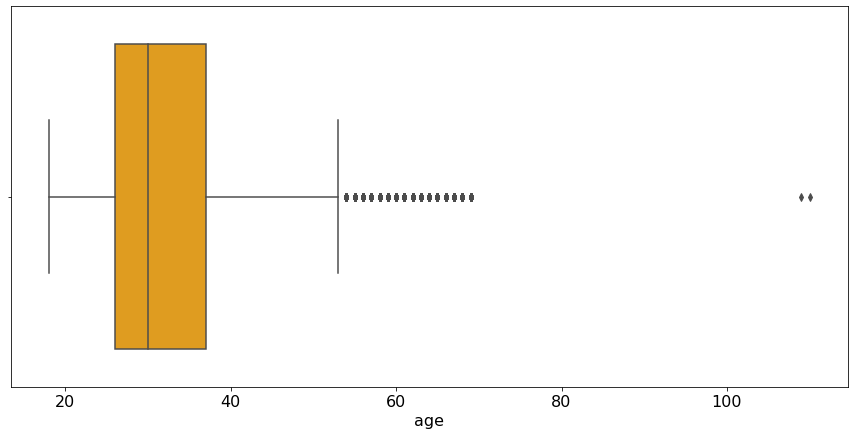

In [ ]:
# plotting the outliers
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(x=dating_df.age, ax=ax, color='orange')
plt.show()

In [ ]:
# checking the 95% quantile range
dating_df.age.quantile(.95)

52.0

There are people aged 110 in the data which is abit peculiar therefore we will go ahead and cap the ages above the 95% quantile. The capping off age is at 52.

In [ ]:
# capping of ages above the 95% quantile to be the same value as the 95% quantile
def age_capoff(value, cap_off_age=52):
  if value > cap_off_age:
        return cap_off_age

  return value

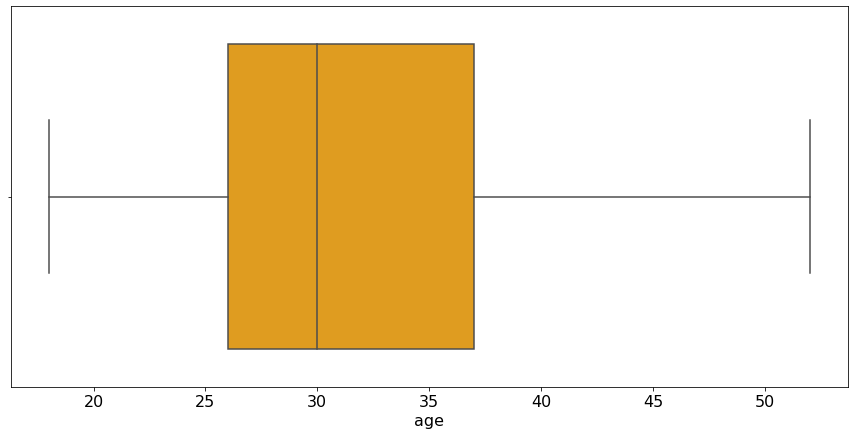

In [ ]:
# plotting after dealing with the outliers
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(x=dating_df.age.apply(lambda x: age_capoff(x)), ax=ax, color='orange')
plt.show()

In [ ]:
# replacing the values in the age column
dating_df.age = dating_df.age.apply(lambda x: age_capoff(x))

### 1.6.19 Checking For Abnormality

**The drugs columns**

In [ ]:
# checking for abnormality
drugs_df = dating_df[['drugs','smokes','drinks','drugs2','smokes2','drinks2']]
drugs_df.sample(20, replace=True)

,drugs,smokes,drinks,drugs2,smokes2,drinks2
4071,never,no,socially,0,0,1
13950,never,no,Unspecified,0,0,2
48680,Unspecified,no,socially,2,0,1
18400,never,no,socially,0,0,1
37369,never,no,socially,0,0,1
41327,never,no,socially,0,0,1
43370,never,Unspecified,Unspecified,0,2,2
7878,never,no,socially,0,0,1
31191,never,no,socially,0,0,1
46682,sometimes,no,not at all,1,0,0


In [ ]:
display(drugs_df.shape)
dating_df.shape

(57559, 6)

(57559, 28)

In [ ]:
dating_df.duplicated().sum()

19

We noticed that there are people who fill in that they do not use drugs yet smoke or drink. We will also remove the 19 duplicates in the column below.

In [ ]:
# it can be deduced that some users use drugs but still fill
# they ain't using drugs hence a function will help to set them 
# to True
# This function also removes duplicates
def drug_confimer(df):
    smokes_df = df[ df['smokes2'] == 1]
    # filling drugs column with nulls
    smokes_df.loc[:, 'drugs2'] = 1

    # doing the same with the drinks column
    drinks_df = df[ df['drinks2'] == 1]
    # filling drugs column with nulls
    drinks_df.loc[:, 'drugs2'] = 1

    # fetching only those that do not use any drug at all
    no_drugs_df = df[ (df['drugs2']== 0) &  (df['smokes2']== 0) & (df['drinks2']== 0) ]

    # concating all the dfs
    final_df = pd.concat([smokes_df, drinks_df, no_drugs_df])

    # dropping_duplicates
    final_df.drop_duplicates(inplace=True)

    return final_df

In [ ]:
cleaned_dating_df = drug_confimer(dating_df)
cleaned_dating_df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(54519, 28)

In [ ]:
cleaned_dating_df.duplicated().sum()

0

In [ ]:
# checking if the function worked
cleaned_dating_df[['drugs','smokes','drinks','drugs2','smokes2','drinks2']].sample(20, replace=True, random_state=100)

,drugs,smokes,drinks,drugs2,smokes2,drinks2
40283,never,no,socially,1,0,1
5689,sometimes,no,socially,1,0,1
2850,never,no,socially,1,0,1
485,sometimes,yes,socially,1,1,1
8750,never,no,socially,1,0,1
9355,never,no,socially,1,0,1
5853,never,no,socially,1,0,1
59923,never,sometimes,socially,1,1,1
14845,never,no,socially,1,0,1
5347,Unspecified,no,socially,1,0,1


In [ ]:
# further analysis
cleaned_dating_df[cleaned_dating_df.drugs2 == True ][['drugs','smokes','drinks','drugs2','smokes2','drinks2']].sample(20, replace=True)

,drugs,smokes,drinks,drugs2,smokes2,drinks2
31898,never,no,socially,1,0,1
28191,never,no,socially,1,0,1
36647,never,Unspecified,often,1,2,1
16707,never,no,socially,1,0,1
17088,never,sometimes,socially,1,1,1
12657,Unspecified,when drinking,often,1,1,1
49549,sometimes,no,rarely,1,0,1
50553,sometimes,when drinking,socially,1,1,1
32884,never,no,rarely,1,0,1
14122,never,no,socially,1,0,1


### 1.6.19 Exporting Cleaned Data

In [ ]:
# exporting the cleaned data
# cleaned_dating_df.to_csv('/content/drive/MyDrive/patamchumbadata/dating_df_cleaned.csv', index=True)

## 1.7 Exploratory Data Analysis
In the EDA section we will create a number of visualizations to have a better understanding of our data and its attributes.

In [ ]:
#Function that will help in allocating percentages to different features in our plots.
def feature_percentage(plot, variable):
    total = len(variable)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x()+p.get_width()/2-0.1
        y = p.get_y()+p.get_height()
        ax.annotate(percentage, (x, y), size=10)

### 1.7.1 Gender Analysis.

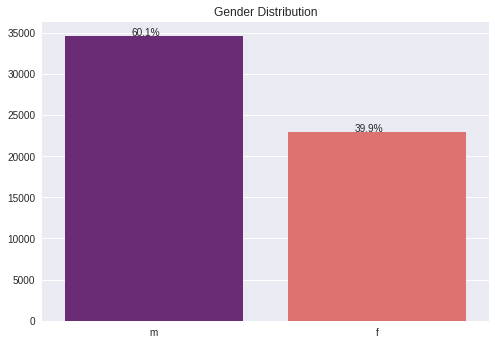

In [ ]:
gender = dating_df['sex'].value_counts()
ax=sns.barplot(x=gender.index, y=gender.values, palette='magma')
plt.title('Gender Distribution')

plt.style.use('seaborn')
feature_percentage(ax,dating_df)
plt.show()

From the above plot majority of the users are male at 60.1% and female follow closely at 39.9%

### 1.7.2 Age Analysis

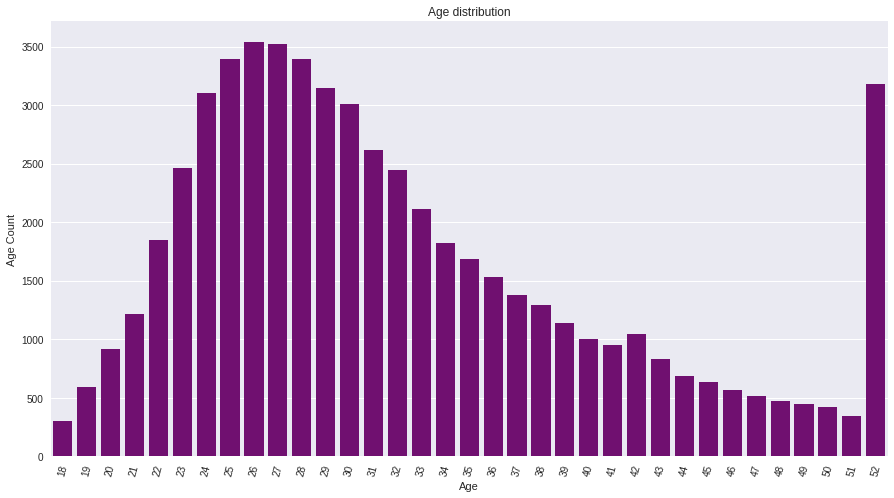

In [ ]:
#Plot showing age distribution
#plt.hist(x=dating_df.age)
age= dating_df['age'].value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x=age.index, y=age.values,color='purple')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Age Count')
plt.style.use('seaborn')
plt.xticks(rotation=75)
plt.show()

Majority of the users are between 22 and 35. However there seems to be odd ages on the dating site such as 109.

In [ ]:
#Checking for the minimum age and maximum age
print("min age:", dating_df['age'].min())
print("max age:", dating_df['age'].max())

min age: 18
max age: 52


In [ ]:
# Binning the ages to allow for better visualization
dating_df['age_bin']=pd.cut(x=dating_df['age'],bins=list(range(18,52,5)))

<Figure size 1440x720 with 0 Axes>

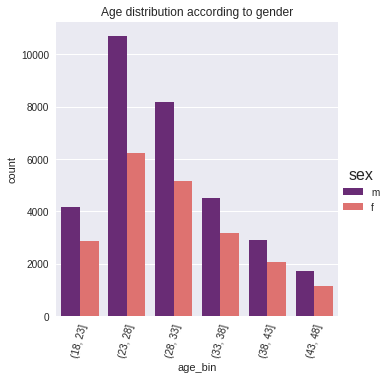

In [ ]:
#Plotting the age distribution
plt.figure(figsize=(20,10))
sns.catplot(x='age_bin', data= dating_df, kind='count',palette='magma',hue='sex')
plt.xticks(rotation=75)
plt.title('Age distribution according to gender')
plt.show()


Majority of the users of this app are male. Most of them are aged 23 to 28. That same age bracket holds the highest number of female users.

### 1.7.3 Investigating orientation count
In this section we will investigate orientation count based on each gender.

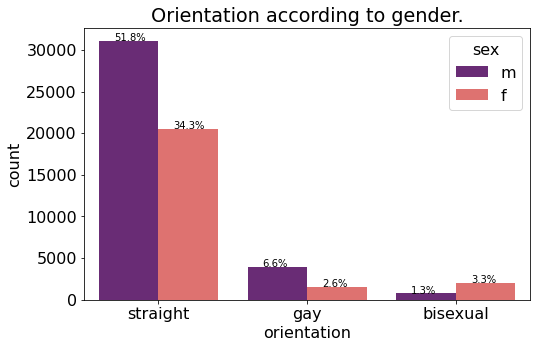

In [ ]:
#Plotting orinetation according to gender
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='orientation', data=dating_df, hue='sex', palette='magma',order=dating_df['orientation'].value_counts().iloc[:10].index) 
total = float(len(dating_df))
plt.title('Orientation according to gender.')
feature_percentage(ax,dating_df)
plt.show()


Majority of the users are of the orientation straight. Most of the straight users are male. This is the same case for the gay orientation For the bisexual orientation, majority are female.



###1.7.4 Investigating drug usage
In this section we investigate 3 columns i.e `drugs`, `drinks` and `smokes`


In [ ]:
#Drugs column
dating_df['drugs'].value_counts()

never          36428
Unspecified    13506
sometimes       7235
often            390
Name: drugs, dtype: int64

From the above information majority of the users do not drink while the minority drink often. We will visualize this in the plot below

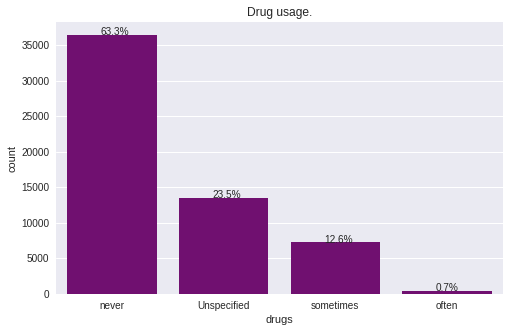

In [ ]:

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='drugs', data=dating_df,  color='purple',order=dating_df['drugs'].value_counts().iloc[:10].index) 
total = float(len(dating_df))
plt.title('Drug usage.')
feature_percentage(ax,dating_df)
plt.show()

It is evident that majority of the users(63.3%) do not do drugs.

###1.7.5 Investigating smoking frequency

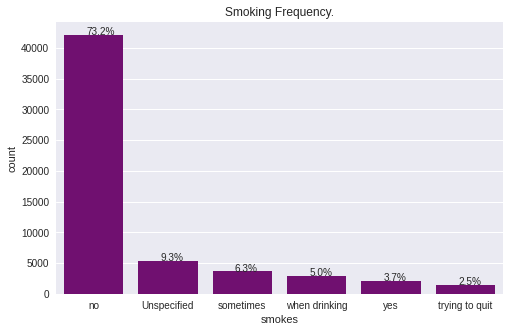

In [ ]:
#Visualization to show the count of users per smoking frequency.
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='smokes', data=dating_df,  color='purple',order=dating_df['smokes'].value_counts().iloc[:10].index) 
total = float(len(dating_df))
plt.title('Smoking Frequency.')
feature_percentage(ax,dating_df)
plt.show()

73.2% of the dating app users do not smoke while those trying to quit take the lowest percentage at 2.5%

### 1.7.6 Alcohol Consumption

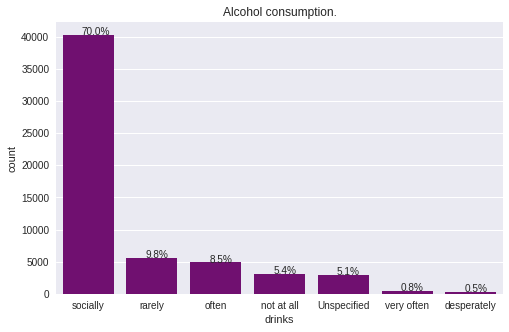

In [ ]:
#Visualizing the frequency of alcohol consumption among the users
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='drinks', data=dating_df,  color='purple',order=dating_df['drinks'].value_counts().iloc[:10].index) 
total = float(len(dating_df))
plt.title('Alcohol consumption.')
feature_percentage(ax,dating_df)
plt.show()

Majority are social drinkers at 70%

###1.7.7 Diet preferences


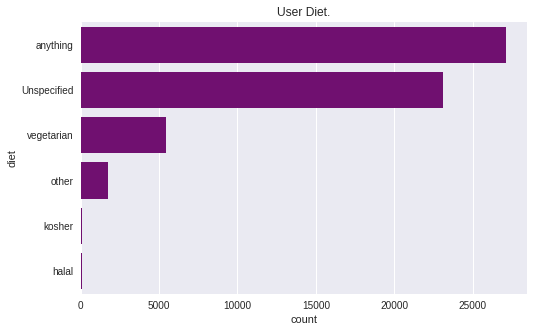

In [ ]:
#Checking the distribution of diet preferences among the users.
plt.figure(figsize=(8, 5))
ax = sns.countplot(y='diet', data=dating_df,order=dating_df['diet'].value_counts().iloc[:10].index, color='purple') 
total = float(len(dating_df))
plt.title('User Diet.')

plt.show()

Majority of the users eat anything. They do not have any diet restrictions.

###1.7.7 Pets preferences

In [ ]:
dating_df.pets.value_counts()

8    21696
0    19382
6    11048
7     2494
5     2301
4      287
3      188
1      121
2       42
Name: pets, dtype: int64

In [ ]:
le.inverse_transform(dating_df.pets.value_counts().index)

array(['likes dogs and likes cats', 'Unspecified', 'likes dogs',
       'likes dogs and dislikes cats', 'likes cats',
       'dislikes dogs and likes cats', 'dislikes dogs and dislikes cats',
       'dislikes cats', 'dislikes dogs'], dtype=object)

In [ ]:
# creating a pets df
pets_df = pd.DataFrame(data=dating_df.pets.value_counts().values, index=dating_df.pets.value_counts().index, columns=['counts'])
pets_df['relationship'] = le.inverse_transform(dating_df.pets.value_counts().index)
pets_df.head()

,counts,relationship
8,21696,likes dogs and likes cats
0,19382,Unspecified
6,11048,likes dogs
7,2494,likes dogs and dislikes cats
5,2301,likes cats


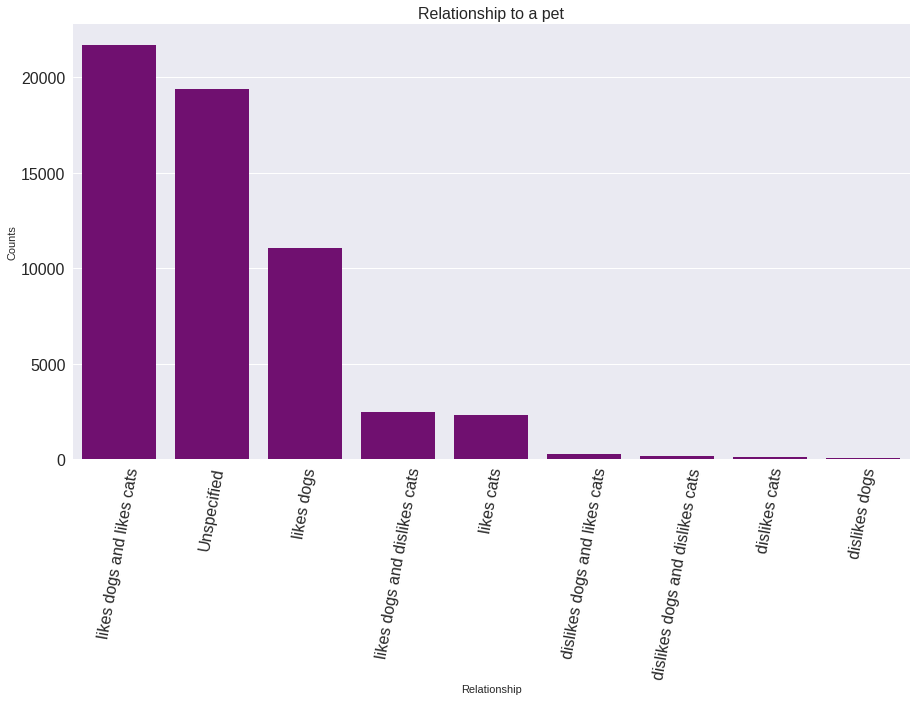

In [ ]:
#Plot showing age distribution
#plt.hist(x=dating_df.age)
plt.figure(figsize=(15,8))
ax=sns.barplot(x=pets_df.relationship, y=pets_df.counts,color='purple')
plt.title('Relationship to a pet', fontsize=16)
plt.xlabel('Relationship')
plt.ylabel('Counts')
plt.style.use('seaborn')
plt.xticks(rotation=80, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## 2.0 Text Cleaning, Preprocessing & More Exploration

Notice the essay columns are untouched upto now. This section will deal with the text data that makes up the essay columns. proper labeling of the columns too.

Then some visualizations before building the model later on.

For starters the following will be performed:
- Remove punctuation and numbers
- Remove links and hyperlinks
- Lowercase everything
- Remove stopwords
- Create a document term matrix grouped by essay 
    - tf-idf vectorization
    - Word2Vec
- Visualize most frequent words
    - word clouds
    - line plot/histogram

Check the dataframe before proceeding; change the essay column titles to something more meaningful

essay meanings:
 - essay
    - 0: My self summary
    - 1: What I’m doing with my life
    - 2: I’m really good at...
    - 3: The first thing people usually notice about me...
    - 4: Favourite books, movies, show, music, and food
    - 5: The six things I could never do without
    - 6: I spend a lot of time thinking about...
    - 7: On a typical Friday night I am...
    - 8: The most private thing I am willing to admit...
    - 9: You should message me if...


In [ ]:
#create a copy of the cleaned dataframe
new_df = cleaned_dating_df.copy()
new_df.head(2)

,age,sex,orientation,body_type,diet,drinks,drugs,education,pets,religion,sign,smokes,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,drinks2,drugs2,religionSerious,signSerious,smokes2,state
0,22,m,straight,a little extra,anything,socially,never,working on college/university,8,agnosticism,gemini,sometimes,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,1,1,1,2,1,california
8,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,8,christianity,gemini,when drinking,NaN,"oh goodness. at the moment i have 4 jobs, so i...",NaN,i'm freakishly blonde and have the same name a...,i am always willing to try new foods and am no...,sports/my softball glove coffee. because nobod...,NaN,"in or out... drinking with friends, maybe a ba...",potential friends/lovers/people who come in co...,http://www.youtube.com/watch?v=4dxbwzuwsxk let...,1,1,0,0,1,california


### 2.1 Tidying the Dataset

In [ ]:
# change the names of essay columns to meaningful words

new_df.rename(columns = {'essay0':'selfSummary', 'essay1':'currentLife', 'essay2':'goodAt',
                     'essay3':'noticeFirst', 'essay4':'Favourites', 'essay5':'preciousThings',
                     'essay6':'thinkAbout', 'essay7':'typicalFriday', 'essay8':'privateAdmission',
                     'essay9':'messageIf'}, inplace = True)

In [ ]:
# check the new column names
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54519 entries, 0 to 59943
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               54519 non-null  int64 
 1   sex               54519 non-null  object
 2   orientation       54519 non-null  object
 3   body_type         54519 non-null  object
 4   diet              54519 non-null  object
 5   drinks            54519 non-null  object
 6   drugs             54519 non-null  object
 7   education         54519 non-null  object
 8   pets              54519 non-null  int64 
 9   religion          54519 non-null  object
 10  sign              54519 non-null  object
 11  smokes            54519 non-null  object
 12  selfSummary       49702 non-null  object
 13  currentLife       47947 non-null  object
 14  goodAt            46072 non-null  object
 15  noticeFirst       44474 non-null  object
 16  Favourites        45339 non-null  object
 17  preciousThin

#### 2.1.1 Dealing with null values and duplicates in the Essay columns

In [ ]:
#check for duplicates in the dataset
new_df.duplicated().sum()

0

In [ ]:
#Filling null values in both data sets
new_df =new_df.fillna('')

### 2.2 Text preprocessing

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
import string
import re
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_validate
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


#### 2.2.1 Cleaning the Essays 

we will use the our two functions together with the map() function to remove the links, tags and user handles from the essays.

In [ ]:
# Use regular expression to clean out the hash tags, links and punctuations from our tweet

def strip_links(text):
    """
    Remove links from our text
    """
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

    

def strip_all_entities(text):
    """
    Remove user handles, hashtags and punctuations from our text
    """
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


Next, map the function above onto our essay columns.

In [ ]:
# map the functions onto the data set
new_df['selfSummary'] = new_df.selfSummary.map(lambda x: strip_all_entities(strip_links(x)))
new_df['currentLife'] = new_df.currentLife.map(lambda x: strip_all_entities(strip_links(x)))
new_df['goodAt'] = new_df.goodAt.map(lambda x: strip_all_entities(strip_links(x)))
new_df['noticeFirst'] = new_df.noticeFirst.map(lambda x: strip_all_entities(strip_links(x)))
new_df['Favourites'] = new_df.Favourites.map(lambda x: strip_all_entities(strip_links(x)))
new_df['preciousThings'] = new_df.preciousThings.map(lambda x: strip_all_entities(strip_links(x)))
new_df['thinkAbout'] = new_df.thinkAbout.map(lambda x: strip_all_entities(strip_links(x)))
new_df['typicalFriday'] = new_df.typicalFriday.map(lambda x: strip_all_entities(strip_links(x)))
new_df['privateAdmission'] = new_df.privateAdmission.map(lambda x: strip_all_entities(strip_links(x)))
new_df['messageIf'] = new_df.messageIf.map(lambda x: strip_all_entities(strip_links(x)))

In [ ]:
# Combining all 10 essays to a single column for each user
# Also fixing missing essays to blank values
new_df['all_essays'] = ''
essay_names = new_df.loc[:,['selfSummary','goodAt','Favourites','typicalFriday']]
for essay_name in essay_names:
    new_df[essay_name] = new_df[essay_name].replace(np.nan, ' ')
    new_df['all_essays'] = new_df[essay_name] + ' ' + new_df['all_essays']

### 2.3 Tokenizing the essays

Let's remove the stopwords from our data set, ensure the words are in lower case, and then tokenize our dataset.



In [ ]:
# create a word tokenize
def tokenize_data(text):
    """
    A function responsible for tokenizing our sentences
    """
    # tokenize the data
    tokens = word_tokenize(text)

    # create our stopwords
    stopwords_list = stopwords.words('english')
    stopwords_list += [str(x) for x in range(100)]

    # convert everything to lowercase
    clean_list = [word.lower() for word in tokens if word.lower() not in stopwords_list]

    return clean_list

Next, map the function above onto our essay columns.

In [ ]:
# map the function above onto the columns

new_df['selfSummary'] = new_df.selfSummary.map(lambda x: tokenize_data(x))
new_df['currentLife'] = new_df.currentLife.map(lambda x: tokenize_data(x))
new_df['goodAt'] = new_df.goodAt.map(lambda x: tokenize_data(x))
new_df['noticeFirst'] = new_df.noticeFirst.map(lambda x: tokenize_data(x))
new_df['Favourites'] = new_df.Favourites.map(lambda x: tokenize_data(x))
new_df['thinkAbout'] = new_df.thinkAbout.map(lambda x: tokenize_data(x))
new_df['typicalFriday'] = new_df.typicalFriday.map(lambda x: tokenize_data(x))
new_df['privateAdmission'] = new_df.privateAdmission.map(lambda x: tokenize_data(x))
new_df['messageIf'] = new_df.messageIf.map(lambda x: tokenize_data(x))
new_df['all_essays'] = new_df.all_essays.map(lambda x: tokenize_data(x))

In [ ]:
new_df.to_csv('tokenized1_data.csv')

In [ ]:
#create a copy of the cleaned dataframe
tokenized_df = new_df.copy()
tokenized_df .head(2)

,age,sex,orientation,body_type,diet,drinks,drugs,education,pets,religion,sign,smokes,selfSummary,currentLife,goodAt,noticeFirst,Favourites,preciousThings,thinkAbout,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
0,22,m,straight,a little extra,anything,socially,never,working on college/university,8,agnosticism,gemini,sometimes,"[would, love, think, kind, intellectual, eithe...","[currently, working, international, agent, fre...","[making, people, laugh, ranting, good, salting...","[way, look, six, foot, half, asian, half, cauc...","[books, absurdistan, republic, mice, men, book...",food water cell phone shelter,"[duality, humorous, things]","[trying, find, someone, hang, anything, except...","[new, california, looking, someone, wisper, se...","[want, swept, feet, tired, norm, want, catch, ...",1,1,1,2,1,california,"[trying, find, someone, hang, anything, except..."
8,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,8,christianity,gemini,when drinking,[],"[oh, goodness, moment, jobs, nice, find, one, ...",[],"[freakishly, blonde, name, hurricane, back]","[always, willing, try, new, foods, picky, howe...",sports my softball glove coffee because nobody...,[],"[drinking, friends, maybe, bar, dancing, pants...","[potential, friends, lovers, people, come, con...","[let, fun, maybe, get, little, trouble]",1,1,0,0,1,california,"[drinking, friends, maybe, bar, dancing, pants..."


### 2.4 Lemmatizing the essay columns

After cleaning and tokenizing our data, the next step in our text preparation will be lemmatization. Lemmatization helps in transforming the text data by removing the suffixes of our data. Since lemmatizing uses part-of-speech tagging to determine how to transform a word, we'll need to incoperate word net in the lammetization.

Based on this below, i will create a function that converts the nltk parts-of-speech to wordnet tags. basically inputs the nltk pos tags and outputs the wordnet lemmatizer tags that can be interpretted by out lemmatizier

In [ ]:
# from nltk download averaged_perceptron_tagger
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [ ]:
# from nltk download tagsets
nltk.download('tagsets', quiet=True)

True

In [ ]:
# create a function that takes in the nltk POS tags and transforms them to wordnet tags
def wordnet_pos(word_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Below i will index out the first user essay based on self summary, then perform POS tagging on the indexed essays.

Based on the output above, we have have successfully gotten the the pos tags where the terms starting with `N` represent the nouns, `J` represents the adjective, `V` represents the verbs

Next, we will instantiate the lemmatizer and create a variable e.g X that contains the data from the column selfSummary.

#### 2.4.1 Lemmatizing all essay Columns

In [ ]:
# inastantiate the lemmatizer
lemmatizer = WordNetLemmatizer() 

In [ ]:
# create various essay variable that contains the data from the essay columns 
selfSummary = tokenized_df['selfSummary']
currentLife = tokenized_df['currentLife']
goodAt = tokenized_df['goodAt']
noticeFirst = tokenized_df['noticeFirst']
Favourites = tokenized_df['Favourites']
preciousThings = tokenized_df['preciousThings']
thinkAbout = tokenized_df['thinkAbout']
typicalFriday = tokenized_df['typicalFriday']
privateAdmission = tokenized_df['privateAdmission']
messageIf = tokenized_df['messageIf']
all_essays =tokenized_df['all_essays']

In the code cell below, we will create a function that takes in the text from the variable X, gets the Pos tags of the text, then uses the wordnet_pos function above to get the wordnet tags that are then passed on to our lemmatizer.

In [ ]:
def word_lemma(text):
    '''
    Translate the text POS tags to Word net tags then pass it to the lemmatizer
    
    '''
    # get the pos tags for the text
    word_pos_tags = pos_tag(text)
    
    # translate the pos tags to word net tags
    word_net_tag = [(text[0], wordnet_pos(text[1])) for text in word_pos_tags]
    
    # Pass the text with the wordnet tags to the lemmatizer
    lemma_word = [lemmatizer.lemmatize(text[0], text[1]) for text in word_net_tag]
    
    return lemma_word
    

Map the function created above onto the essay variables created above to lemmetize each essay column.

In [ ]:
# map the function above
tokenized_df['selfSummary'] = selfSummary.map(lambda x: word_lemma(x))
tokenized_df['currentLife'] = currentLife.map(lambda x: word_lemma(x))
tokenized_df['goodAt'] = goodAt.map(lambda x: word_lemma(x))
tokenized_df['noticeFirst'] = noticeFirst.map(lambda x: word_lemma(x))
tokenized_df['Favourites'] = Favourites.map(lambda x: word_lemma(x))
tokenized_df['thinkAbout'] = thinkAbout.map(lambda x: word_lemma(x))
tokenized_df['typicalFriday'] = typicalFriday.map(lambda x: word_lemma(x))
tokenized_df['privateAdmission'] = privateAdmission.map(lambda x: word_lemma(x))
tokenized_df['messageIf'] = messageIf.map(lambda x: word_lemma(x))
tokenized_df['all_essays'] = all_essays.map(lambda x: word_lemma(x))


In [ ]:
tokenized_df.to_csv('lemmatized1_data.csv')

In [ ]:
lemmatized_df = tokenized_df.copy()
lemmatized_df.head(2)

,age,sex,orientation,body_type,diet,drinks,drugs,education,pets,religion,sign,smokes,selfSummary,currentLife,goodAt,noticeFirst,Favourites,preciousThings,thinkAbout,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
0,22,m,straight,a little extra,anything,socially,never,working on college/university,8,agnosticism,gemini,sometimes,"[would, love, think, kind, intellectual, eithe...","[currently, work, international, agent, freigh...","[make, people, laugh, rant, good, salt, find, ...","[way, look, six, foot, half, asian, half, cauc...","[book, absurdistan, republic, mouse, men, book...",food water cell phone shelter,"[duality, humorous, thing]","[try, find, someone, hang, anything, except, c...","[new, california, look, someone, wisper, secret]","[want, sweep, foot, tired, norm, want, catch, ...",1,1,1,2,1,california,"[try, find, someone, hang, anything, except, c..."
8,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,8,christianity,gemini,when drinking,[],"[oh, goodness, moment, job, nice, find, one, c...",[],"[freakishly, blonde, name, hurricane, back]","[always, willing, try, new, food, picky, howev...",sports my softball glove coffee because nobody...,[],"[drink, friend, maybe, bar, dance, pant, watch...","[potential, friend, lover, people, come, conta...","[let, fun, maybe, get, little, trouble]",1,1,0,0,1,california,"[drink, friend, maybe, bar, dance, pant, watch..."


### 2.5 Plot a Frequency Distribution for Key Words.

We will create a frequency distribution plot for all essay columns that shows the words that appear together with the count.

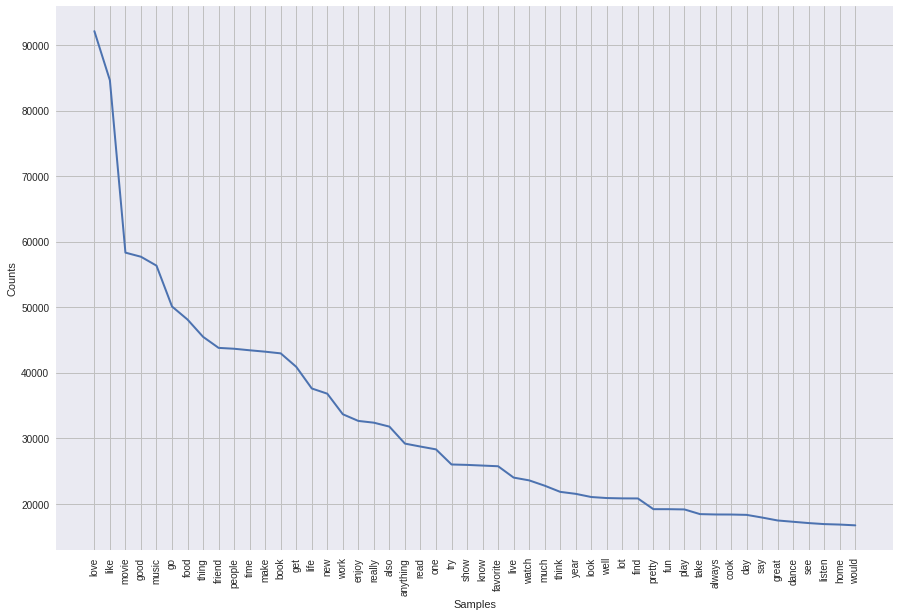

In [ ]:
sample = lemmatized_df['all_essays']
freq1_dist = []

for word in sample:
    freq1_dist.extend(word)
    
fdist = FreqDist(freq1_dist)
plt.figure(figsize=(15, 10))
ax.set_xlabel('x-axis', fontsize = 15)
ax.set_ylabel('y-axis', fontsize = 10)
fdist.plot(50);

The chart above shows most commonly used words in all essays

In the code cell below, we will convert the lists in the essay column into a string.

In [ ]:
# convert the list into a string
lemmatized_df['selfSummary'] = lemmatized_df.selfSummary.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['currentLife'] = lemmatized_df.currentLife.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['goodAt'] = lemmatized_df.goodAt.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['noticeFirst'] = lemmatized_df.noticeFirst.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['Favourites'] = lemmatized_df.Favourites.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['thinkAbout'] = lemmatized_df.thinkAbout.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['typicalFriday'] = lemmatized_df.typicalFriday.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['privateAdmission'] = lemmatized_df.privateAdmission.map(lambda x: ' '.join(map(str, x)))
lemmatized_df['messageIf'] = lemmatized_df.messageIf.map(lambda x: ' '.join(map(str, x)))

In [ ]:
lemmatized_df['all_essays'] = lemmatized_df.all_essays.map(lambda x: ' '.join(map(str, x)))

In [ ]:
lemmatized_df.head(2)

,age,sex,orientation,body_type,diet,drinks,drugs,education,pets,religion,sign,smokes,selfSummary,currentLife,goodAt,noticeFirst,Favourites,preciousThings,thinkAbout,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
0,22,m,straight,a little extra,anything,socially,never,working on college/university,8,agnosticism,gemini,sometimes,would love think kind intellectual either dumb...,currently work international agent freight for...,make people laugh rant good salt find simplici...,way look six foot half asian half caucasian mu...,book absurdistan republic mouse men book make ...,food water cell phone shelter,duality humorous thing,try find someone hang anything except club,new california look someone wisper secret,want sweep foot tired norm want catch coffee b...,1,1,1,2,1,california,try find someone hang anything except club boo...
8,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,8,christianity,gemini,when drinking,,oh goodness moment job nice find one could set...,,freakishly blonde name hurricane back,always willing try new food picky however extr...,sports my softball glove coffee because nobody...,,drink friend maybe bar dance pant watch playin...,potential friend lover people come contact bew...,let fun maybe get little trouble,1,1,0,0,1,california,drink friend maybe bar dance pant watch play g...


### 2.6 Word Cloud Plots

Next, we will plot a word cloud visualization which depicts text in such a way that, the more frequent words appear enlarged as compared to less frequent words. This gives us a little insight into, how the data looks after being processed through all the steps until now.

#### 2.6.1 selfSummary essay wordcloud

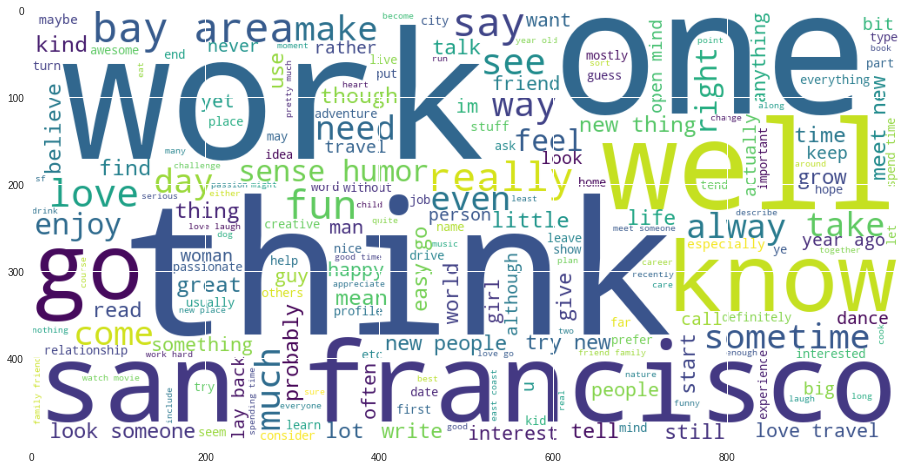

In [ ]:
# plotting a word cloud 

mpl.rcParams['figure.figsize'] = 20,8
sample_data = lemmatized_df['selfSummary']

word_cloud =" "
for row in sample_data:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud);

From the above plot some of the words that stand out are San Francisco which indicates that most of these people live there.

#### 2.6.2 currentLife essay wordcloud

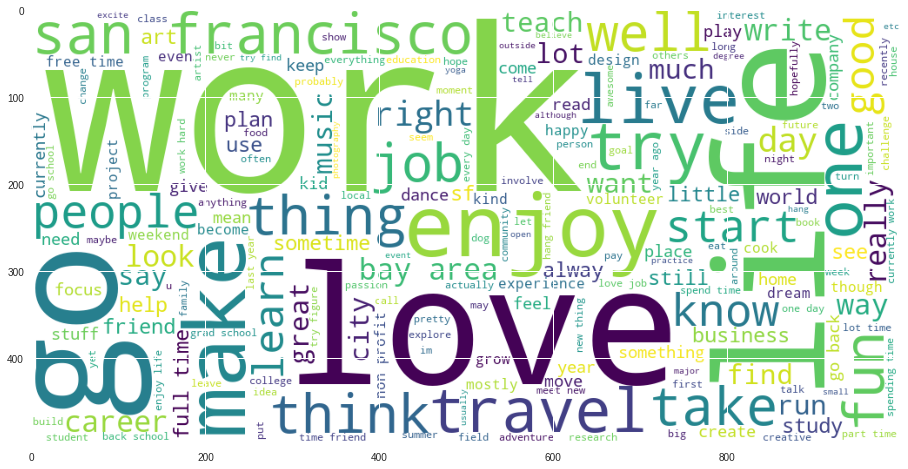

In [ ]:
# plotting a word cloud

mpl.rcParams['figure.figsize'] = 20,8
sample_data = lemmatized_df['currentLife']

word_cloud =" "
for row in sample_data:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud);

#### 2.6.3 goodAt essay wordcloud

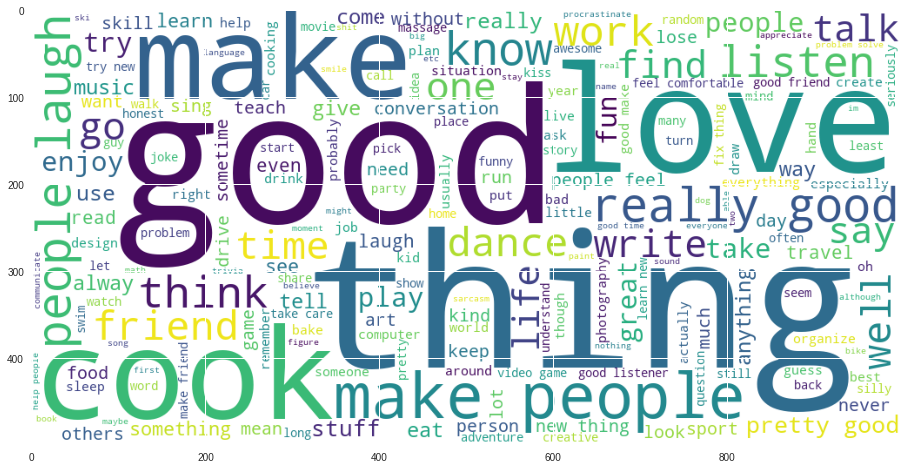

In [ ]:
# plotting a word cloud

mpl.rcParams['figure.figsize'] = 20,8
sample_data = lemmatized_df['goodAt']

word_cloud =" "
for row in sample_data:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud);

#### 2.6.4 Favourites essay wordcloud

In [ ]:
#create heart_shaped mask for wordcloud

from PIL import Image
mask = np.array(Image.open("/content/drive/MyDrive/data/heart.jpg"))

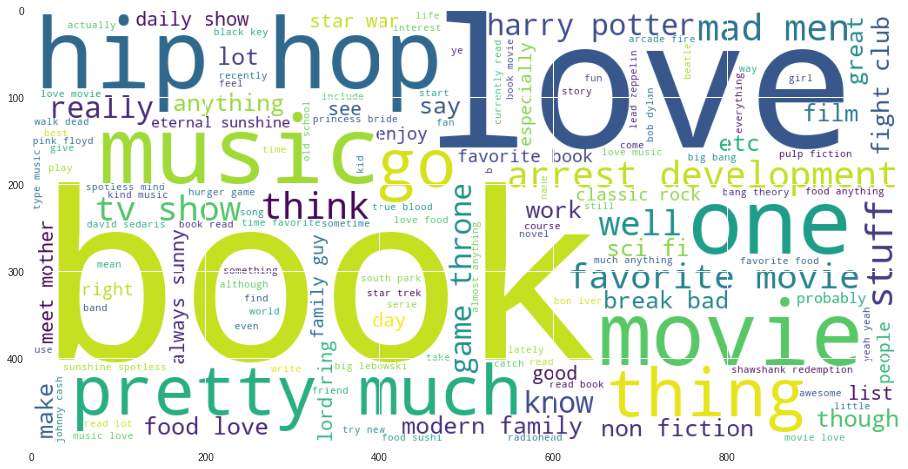

In [ ]:
# plotting a word cloud

mpl.rcParams['figure.figsize'] = 20,8
sample_data = lemmatized_df['Favourites']

word_cloud =" "
for row in sample_data:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500, mask=mask, background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud);

#### 2.6.5 noticeFirst essay wordcloud

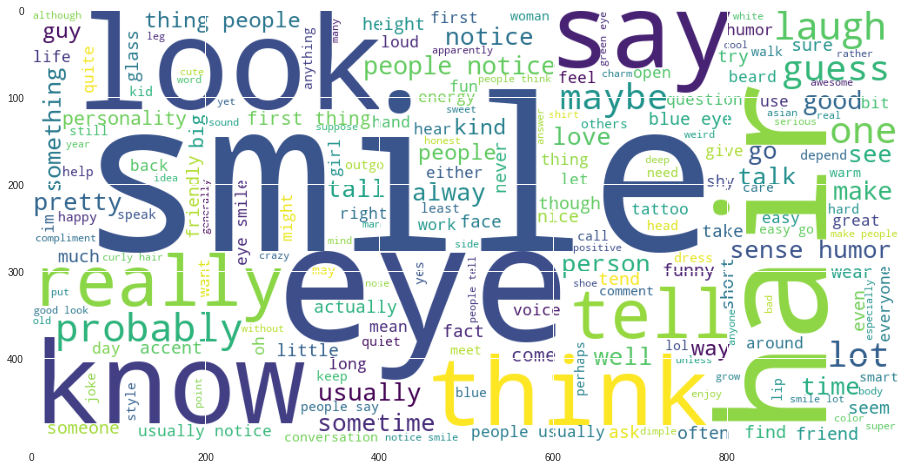

In [ ]:
# plotting a word cloud

mpl.rcParams['figure.figsize'] = 20,8
sample_data = lemmatized_df['noticeFirst']

word_cloud =" "
for row in sample_data:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud);

## 3.0 Modelling
In this section we will create a custom model that iterates through the user details to come up with matches.



### 3.1 Deep Learning Model To predict words based on essays
The purpose of this section was to find the most commonly used words in the essays. This was to aid in predicting some of the columns. For example some users fill in that they dont use drugs but in the essays, they mention that they do use drugs. Further this will be also helpful in predicting the unspecified sections in our data.

In [ ]:
#importing the cleaned df
df = pd.read_csv('/content/drive/MyDrive/patamchumbadata/dating_df_cleaned.csv')

#### 3.1.1 Tidying the Dataset

To make it easier to read and analyse the data, we rename the columns.

In [ ]:
# all of this process will be simplified in function below
def df_tidy(df):
    if 'Unnamed: 0' in df.columns:
       result = df.drop('Unnamed: 0', axis=1)
    else:
        print('Invalid df!! Did not tidy')
        return df

    result.insert(0,'id',result.index+1001,True)
    # change the essay names columns to meaningful words
    result.rename(columns = {'essay0':'selfSummary', 'essay1':'currentLife', 'essay2':'goodAt',
                     'essay3':'noticeFirst', 'essay4':'Favourites', 'essay5':'preciousThings',
                     'essay6':'thinkAbout', 'essay7':'typicalFriday', 'essay8':'privateAdmission',
                     'essay9':'messageIf'}, inplace = True)
    
    # filling null values
    result.fillna('', inplace=True)

    # creating an all essays column
    result['all_essays'] = ''
    essay_names = result.loc[:,['selfSummary','currentLife','goodAt','noticeFirst','Favourites',
                        'typicalFriday','preciousThings','thinkAbout','typicalFriday',
                        'privateAdmission', 'messageIf',]]
    for essay_name in essay_names:
      result[essay_name] = result[essay_name].replace(np.nan, ' ')
      result['all_essays'] = result[essay_name] + ' ' + result['all_essays']


    return result

In [ ]:
df = df_tidy(df)
df.head(2)

,id,age,sex,orientation,body_type,diet,drinks,drugs,education,pets,...,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
0,1001,22,m,straight,a little extra,anything,socially,never,working on college/university,8,...,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,1,1,1,2,1,california,you want to be swept off your feet! you are ti...
1,1002,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,8,...,"in or out... drinking with friends, maybe a ba...",potential friends/lovers/people who come in co...,http://www.youtube.com/watch?v=4dxbwzuwsxk let...,1,1,0,0,1,california,http://www.youtube.com/watch?v=4dxbwzuwsxk let...


#### 3.1.2 Modelling

In [ ]:
all_essays = df.all_essays.apply(gensim.utils.simple_preprocess)
all_essays

0        [you, want, to, be, swept, off, your, feet, yo...
1        [http, www, youtube, com, watch, dxbwzuwsxk, l...
2        [you, are, complex, woman, with, healthy, self...
3        [you, want, to, help, me, assemble, ikea, stuf...
4        [you, like, to, mob, around, on, bikes, and, m...
                               ...                        
54514    [if, if, you, want, once, wrote, softcore, por...
54515    [you, want, to, know, more, about, me, you, li...
54516    [am, funny, easy, to, get, long, with, do, or,...
54517    [if, you, re, looking, for, real, connection, ...
54518    [we, have, similar, interests, please, let, me...
Name: all_essays, Length: 54519, dtype: object

#### 3.1.3 Initializing the model

In [ ]:
model = Word2Vec(window = 10, 
                             min_count =2,
                             workers = 4)

In [ ]:
model.build_vocab(all_essays,progress_per=1000)

In [ ]:
model.epochs

5

In [ ]:
model.corpus_count

54519

In [ ]:
model.train(all_essays,total_examples=model.corpus_count,epochs=model.epochs)

(74930065, 94026915)

In [ ]:
# saving the word2Vec model
# model.save('word2Vec.model')

In [ ]:
# loading the model
word2Vec_model = Word2Vec.load('/content/drive/MyDrive/patamchumbadata/word2Vec.model')

# prdicting using the stored model
# experimenting with drugs similar to drugs
word2Vec_model.wv.most_similar('drugs')

[('drug', 0.6984121799468994),
 ('smokers', 0.6967443823814392),
 ('smoke', 0.6745352745056152),
 ('alcohol', 0.6466299295425415),
 ('abuse', 0.6424536108970642),
 ('drinkers', 0.6232854127883911),
 ('dishonesty', 0.5879920125007629),
 ('flakes', 0.5847262144088745),
 ('anti', 0.5767168998718262),
 ('smoker', 0.5644427537918091)]

In [ ]:
# function for fetching words similar to the given in the parameter

def word_fetcher(word, model):
    # storing similar words in a list
    
    similar_words = [word for word, _ in model.wv.most_similar(word)]
    return similar_words

In [ ]:
# trying using drugs

drug_words = word_fetcher('drugs', word2Vec_model)
drug_words

['drug',
 'smokers',
 'smoke',
 'alcohol',
 'abuse',
 'drinkers',
 'dishonesty',
 'flakes',
 'anti',
 'smoker']

In [ ]:
# finding words similar to smoking

smokes_words = word_fetcher('smoking', word2Vec_model)
smokes_words

['smokin',
 'lock',
 'barrels',
 'smoke',
 'stock',
 'weed',
 'cigarettes',
 'hookah',
 'cig',
 'jger']

In [ ]:
# finding words similar to drinking

smokes_words = word_fetcher('alcohol', word2Vec_model)
smokes_words

['booze',
 'cigarettes',
 'drugs',
 'smoke',
 'alcoholic',
 'whiskey',
 'pot',
 'smokers',
 'vodka',
 'dairy']

To preditct the columns which we labeled as unspecified in the data cleaning part, we will create a function will try to fill the unspecified fields

In [ ]:
list(df.columns)

['id',
 'age',
 'sex',
 'orientation',
 'body_type',
 'diet',
 'drinks',
 'drugs',
 'education',
 'pets',
 'religion',
 'sign',
 'smokes',
 'selfSummary',
 'currentLife',
 'goodAt',
 'noticeFirst',
 'Favourites',
 'preciousThings',
 'thinkAbout',
 'typicalFriday',
 'privateAdmission',
 'messageIf',
 'drinks2',
 'drugs2',
 'religionSerious',
 'signSerious',
 'smokes2',
 'state',
 'all_essays']

In [ ]:
len(df[ df.drinks2 == 1 ])

51525

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54519 entries, 0 to 54518
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                54519 non-null  int64 
 1   age               54519 non-null  int64 
 2   sex               54519 non-null  object
 3   orientation       54519 non-null  object
 4   body_type         54519 non-null  object
 5   diet              54519 non-null  object
 6   drinks            54519 non-null  object
 7   drugs             54519 non-null  object
 8   education         54519 non-null  object
 9   pets              54519 non-null  int64 
 10  religion          54519 non-null  object
 11  sign              54519 non-null  object
 12  smokes            54519 non-null  object
 13  selfSummary       54519 non-null  object
 14  currentLife       54519 non-null  object
 15  goodAt            54519 non-null  object
 16  noticeFirst       54519 non-null  object
 17  Favourites  

In [ ]:
df.smokes2.value_counts()

0    41040
1    10088
2     3391
Name: smokes2, dtype: int64

This function will not fill the unspecified columns in the df, but will fill a boolean on the other column representing it as a boolean as seen in the data cleaning part

The columns of interest are: 
1.   drinks2
2.   smokes2



In [ ]:
# word checker lambda function

def word_checker(words, all_essays):
    result = any(item in all_essays for item in words)
    if result == True:
        return 1
    else:
        return 0

In [ ]:
# unspecified filler function

def unspecified_filler(words, column, df, indexes):
    df_copy = df.copy()
    for index in indexes:
        essays = df_copy.loc[index, 'all_essays']
        result = word_checker(words, essays)
        # filling the column with the response

        df_copy.loc[index, column] = result


    return df_copy

In [ ]:
df[ df.drinks2 == 2 ].index

Int64Index([   59,   197,   229,   389,   453,   571,   739,   750,   815,
              888,
            ...
             9612,  9695,  9709,  9723,  9733,  9757,  9814,  9907,  9971,
            10005],
           dtype='int64', length=149)

In [ ]:
# unspecified filler function

def drug_filler(df):
    # alcohol words

    alcohol_words = word_fetcher('alcohol', word2Vec_model)
    # smoking words 

    smoking_words = word_fetcher('smoking', word2Vec_model)
    # drinks unspecified indexes

    unspecified_drinking_index = df[ df.drinks2 == 2 ].index
    # smokes unspecified df

    unspecified_smoking_index = df[ df.smokes2 == 2 ].index
    # filling the unspecified records in the unspecified df
    
    result = unspecified_filler(alcohol_words, 'drinks2', df, unspecified_drinking_index)

    # doing the same with the smoking column
    result = unspecified_filler(smoking_words, 'smokes2', result, unspecified_smoking_index)

    return result

In [ ]:
df_final = drug_filler(df)
df_final.head(2)

,id,age,sex,orientation,body_type,diet,drinks,drugs,education,pets,...,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
0,1001,22,m,straight,a little extra,anything,socially,never,working on college/university,8,...,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,1,1,1,2,1,california,you want to be swept off your feet! you are ti...
1,1002,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,8,...,"in or out... drinking with friends, maybe a ba...",potential friends/lovers/people who come in co...,http://www.youtube.com/watch?v=4dxbwzuwsxk let...,1,1,0,0,1,california,http://www.youtube.com/watch?v=4dxbwzuwsxk let...


In [ ]:
df.smokes2.value_counts()

0    41040
1    10088
2     3391
Name: smokes2, dtype: int64

In [ ]:
df_final.smokes2.value_counts()

0    44079
1    10440
Name: smokes2, dtype: int64

In [ ]:
df.drinks2.value_counts()

1    51525
0     2845
2      149
Name: drinks2, dtype: int64

In [ ]:
df_final.drinks2.value_counts()

1    51547
0     2972
Name: drinks2, dtype: int64

In [ ]:
df_final.head(2)

,id,age,sex,orientation,body_type,diet,drinks,drugs,education,pets,...,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
0,1001,22,m,straight,a little extra,anything,socially,never,working on college/university,8,...,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,1,1,1,2,1,california,you want to be swept off your feet! you are ti...
1,1002,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,8,...,"in or out... drinking with friends, maybe a ba...",potential friends/lovers/people who come in co...,http://www.youtube.com/watch?v=4dxbwzuwsxk let...,1,1,0,0,1,california,http://www.youtube.com/watch?v=4dxbwzuwsxk let...


In [ ]:
df_final.shape

(54519, 30)

In [ ]:
# passing the final df into the drug_confimer function
df_final = drug_confimer(df_final)
display(df_final.shape)
df_final.head(2)

In [ ]:
# checking if the drugs column contains any unspecified record
df_final.drugs2.value_counts()

In [ ]:
# exporting the final df
# df_final.to_csv('/content/drive/MyDrive/patamchumbadata/final_df')

## 4.0 Matching Functions

Create the following functions for matching
- Match through orientation.
- Match through gender.
- Match through zodiac signs.

### 4.0.1 Function to Match by Orientation

In [ ]:
# importing the cleaned_df 
dating_df = pd.read_csv('/content/drive/MyDrive/patamchumbadata/final_df')
dating_df.head()

,Unnamed: 0,id,age,sex,orientation,body_type,diet,drinks,drugs,education,...,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
0,0,1001,22,m,straight,a little extra,anything,socially,never,working on college/university,...,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,1,1,1,2,1,california,you want to be swept off your feet! you are ti...
1,1,1002,24,f,straight,Unspecified,anything,socially,Unspecified,graduated from college/university,...,"in or out... drinking with friends, maybe a ba...",potential friends/lovers/people who come in co...,http://www.youtube.com/watch?v=4dxbwzuwsxk let...,1,1,0,0,1,california,http://www.youtube.com/watch?v=4dxbwzuwsxk let...
2,2,1003,35,m,straight,average,anything,socially,Unspecified,Unspecified,...,having dinner and drinks with friends and/or w...,i used to wish for a jetpack when blowing out ...,you are a complex woman with healthy self-este...,1,1,2,2,1,california,you are a complex woman with healthy self-este...
3,3,1004,33,m,straight,fit,Unspecified,socially,Unspecified,working on masters program,...,i just moved here and am still getting to know...,i am in my 30's and still cannot grow a mustac...,you want to help me assemble ikea stuff and/or...,1,1,2,0,1,california,you want to help me assemble ikea stuff and/or...
4,4,1005,33,m,straight,thin,anything,socially,sometimes,graduated from college/university,...,being thrifty,NaN,you like to mob around on bikes and make fun o...,1,1,1,2,1,california,you like to mob around on bikes and make fun o...


### 4.0.1 Function to Match by Orientation
This function will enable us to match the users in terms of their orientation. Straight people will be matched with the opposite gender from the straight category.
Gay users will also be matched wih gay users. 

In [ ]:
# function for matching orientation
def orientation_matcher(orientation, gender, df):
    if orientation == 'straight':
        df = df[(df['orientation'] == 'straight') | (df['orientation'] == 'bisexual')]
        if gender == 'm':
          return df[df['sex'] == 'f']
        elif gender == 'f':
          return df[ df['sex'] == 'm']
        else:
            return df
    elif orientation == 'gay':
        df = df[ (df['orientation'] == 'gay') | (df['orientation'] == 'bisexual') ]
        if gender == 'm':
          return df[df['sex'] == 'm']
        elif gender == 'f':
          return df[df['sex'] == 'f']
        else:
            return df
    elif orientation == 'bisexual':
        if gender == 'm':
          return df[ (df['sex'] == 'm') | (df['sex'] == 'f')]
        elif gender == 'f':
          return df[ (df['sex'] == 'f') | (df['sex'] == 'm')]
        else:
            return df
    else:
        return df

In [ ]:
orientation_matcher('straight', 'm', dating_df).sex.value_counts()

f    20498
Name: sex, dtype: int64

### 4.0.2 Function to Match by zodiac signs

In [ ]:
# function for matching zodiac sign
def sign_matcher(orientation, gender, df, sign, sign_serious):
  compatibility = {
    'aries': ['gemini', 'taurus'],
    'taurus': ['aries', 'libra'],
    'gemini': ['pisces', 'virgo'],
    'cancer': ['taurus', 'scorpio'],
    'virgo': ['aquarius', 'sagittarius'],
    'libra': ['virgo', 'cancer'],
    'scorpio': ['pisces','leo'],
    'sagittarius': ['pisces', 'capricon'],
    'capricon': ['aquarius','taurus'],
    'aquarius': ['capricon', 'sagittarius'],
    'pisces': ['scorpio', 'gemini'],
    'leo': ['sagittarius', 'cancer']
    }

  if sign_serious == 1:
    df = orientation_matcher(orientation, gender, df)
    result = df[ (df['sign'] == compatibility[sign][0]) | (df['sign'] == compatibility[sign][1]) ]
    return result[ (result.signSerious == 1) | (result.signSerious == 0) ]

  return df

In [ ]:
sign_matcher('straight', 'f', dating_df, 'leo', 1).sign.value_counts()

cancer         1478
sagittarius    1335
Name: sign, dtype: int64

### 4.0.3 Function to Match by drug usage
This section matches drug users to drug users.

In [ ]:
# function for matching drug users
def drug_matcher(orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2):
    df = sign_matcher(orientation, gender, df, sign, sign_serious)

    if drugs2 == 1:
        if drinks2 == 1 and smokes2 == 1:
            return df[ (df['drinks2']== 1) | (df['smokes2']==1) ]
        elif drinks2 == 1 and smokes2 == 0:
              return df[ ~(df['drinks2']== 0) ]
        elif drinks2 == 0 and smokes2 == 1:
              return df[ ~(df['smokes2']== 0) ]
    else:
      return df[ (df['drinks2']==0) & (df['smokes2']==0) ]

In [ ]:
# investigating if the function works
drug_matcher('straight', 'f', dating_df, 'capricon', sign_serious=0, drugs2=1, smokes2=1, drinks2=1).drugs2.value_counts()

1    52089
Name: drugs2, dtype: int64

### 4.0.4 Function to Match by Religion

Subsequently, users will be matched according to their preferred religions. People will mostly prefer to be with someone that belongs to the same religion as them.

In [ ]:
dating_df.religion.value_counts()

Unspecified     17686
agnosticism      8130
other            7140
atheism          6304
christianity     5491
catholicism      4552
judaism          2884
buddhism         1785
hinduism          425
islam             122
Name: religion, dtype: int64

In [ ]:
def religion_matcher(orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2, religion_serious, religion):
    # getting the filtered  from the drug matching function
    df = drug_matcher(orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2)
    
    if religion_serious == 1:
        return df[ (df.religionSerious == 1) & (df.religion == religion) ]
    
    return df

In [ ]:
religion_matcher('straight', 'f', dating_df, 'capricon', sign_serious=1, drugs2=0, smokes2=0, drinks2=0, religion_serious=1, religion='atheism')[['drugs2', 'drinks2', 'smokes2', 'religionSerious', 'religion']]

,drugs2,drinks2,smokes2,religionSerious,religion
52121,0,0,0,1,atheism
52574,0,0,0,1,atheism
52751,0,0,0,1,atheism
53019,0,0,0,1,atheism
53185,0,0,0,1,atheism
53224,0,0,0,1,atheism
53668,0,0,0,1,atheism
53726,0,0,0,1,atheism
54055,0,0,0,1,atheism
54377,0,0,0,1,atheism


In [ ]:
religion_matcher('straight', 'f', dating_df, 'capricon', sign_serious=1, drugs2=1, smokes2=1, drinks2=1, religion_serious=1, religion='islam').religion.value_counts()

islam    4
Name: religion, dtype: int64

### 4.0.4 Age gap function
A user will be able to specify the age gap between them and their potential partners.

In [ ]:
dating_df[ dating_df.age <= 20 ].age.value_counts()

20    832
19    516
18    266
Name: age, dtype: int64

In [ ]:
def age_gap(orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2, religion_serious, religion, age, gap):
    df = religion_matcher(orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2, religion_serious, religion)
    age_limit = age + gap

    if age <= 21:
      result = df[ (df.age <= age_limit) ]
      return result
    else:
      age_limit_lower = age - gap
      return df[ (df.age >= age_limit_lower) & (df.age <= age_limit)]

In [ ]:
age_gap('straight', 'f', dating_df, 'capricon', sign_serious=1, drugs2=1, smokes2=1, drinks2=1, religion_serious=1, religion='atheism', age=21, gap=3)[['drugs2', 'drinks2', 'smokes2', 'religionSerious', 'religion', 'age']]

,drugs2,drinks2,smokes2,religionSerious,religion,age
1862,1,1,1,1,atheism,24
2285,1,1,1,1,atheism,21
2339,1,1,1,1,atheism,23
3088,1,1,1,1,atheism,23
3209,1,1,1,1,atheism,20
3403,1,1,1,1,atheism,20
3554,1,1,1,1,atheism,18
4016,1,1,1,1,atheism,20
4383,1,1,1,1,atheism,20
4532,1,1,1,1,atheism,23


In [ ]:
age_gap('straight', 'f', dating_df, 'capricon', sign_serious=1, drugs2=1, smokes2=1, drinks2=1, religion_serious=1, religion='atheism', age=25, gap=3).age.value_counts().sort_values(ascending=False)

27    18
28    17
24    14
25    14
23    10
26     9
22     3
Name: age, dtype: int64

## 4.0 Final Model
This final model will be a hybrid one. This will includes the above model and a model that matches users depending on the essays. It is created by checking for sentence similarity in the essays provided by each user. 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel

# get recommendation function
def give_recommendation(series,df,id,sig):
    idx=series[id]
    sigmoid_score= list(enumerate(sig[idx]))
    sigmoid_score=sorted(sigmoid_score, key=lambda x:x[1],reverse=True)
    sigmoid_score=sigmoid_score[1:30]
    user_indexes=[i[0] for i in sigmoid_score]
    
    return df["id"].iloc[user_indexes]

In [ ]:
def profile_viewer(df, id, name='Unspecified'):
    record_list = df[ df.index == id ].squeeze()
    print(name,'\n')
    print(record_list)

    return 0

In [ ]:
dating_df[ dating_df.index == 5030 ]

,Unnamed: 0,id,age,sex,orientation,body_type,diet,drinks,drugs,education,...,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
5030,5030,6031,19,m,straight,average,anything,socially,sometimes,dropped out of space camp,...,drinking beer and listening to music with frie...,i don't have anything to hide. ask me anything...,you aren't super pretentious,1,1,0,2,1,california,you aren't super pretentious i don't have anyt...


In [ ]:
def all_essays_getter(id, df):
    all_essays = df[ df.id == id].all_essays
    return all_essays

In [ ]:
def records_fetcher(matches, df):
    # # creating an empty dataFrame
    # result = pd.DataFrame()

    # for userid in user_matches.values:
    #     user_info = df[ df.id == userid ]
    #     result = pd.concat([result, user_info])
    result = df.loc[matches.index]

    return result

In [ ]:
def final_model(orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2, religion_serious, religion, age, gap, id):
    filtered_df = age_gap(orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2, religion_serious, religion, gap, age)

    # profile_viewer(df, id, 'User to predict info')
    # creating an instanse of the vectorizer 
    tfv=TfidfVectorizer(min_df=3,max_features =None, strip_accents= "unicode",analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1,3),stop_words='english')
    
    # fitting the vectorizer
    tfv_matrix=tfv.fit_transform(filtered_df.all_essays)

    # calling the sigmoid_kernel function
    sig=sigmoid_kernel(tfv_matrix,tfv_matrix)

    index1=pd.Series(df.index,index=df["id"]).drop_duplicates()

    # getting the recommendations
    recommendations = give_recommendation(index1, filtered_df, id, sig)

    # gettting the recommnedations in a dataframe format
    # recommendations_df = records_fetcher(recommendations.values, filtered_df)
    

    return recommendations, filtered_df

In [ ]:
# testing the final_model (also a hybrid model)
user_matches, fdf = final_model('straight', 'f', dating_df, 'capricon', sign_serious=1, drugs2=1, smokes2=1, drinks2=1, religion_serious=1, religion='atheism', age=21, gap=3, id=1030)
user_matches

3209      4210
4532      5533
15507    16508
7446      8447
11759    12760
42262    43263
39389    40390
36866    37867
10617    11618
4383      5384
14151    15152
27297    28298
36477    37478
12537    13538
49378    50379
20851    21852
18331    19332
20984    21985
22905    23906
10174    11175
51601    52602
24183    25184
49272    50273
43719    44720
26492    27493
18633    19634
43186    44187
5956      6957
6902      7903
Name: id, dtype: int64

In [ ]:
records_fetcher(user_matches, fdf).sex.value_counts()

m    29
Name: sex, dtype: int64

In [ ]:
matches2, fdf2 = final_model('gay', 'f', dating_df, 'virgo', sign_serious=1, drugs2=1, smokes2=1, drinks2=1, religion_serious=0, religion='agnosticism', age=29, gap=3, id=1030)
matches2

4136      5137
5295      6296
29022    30023
4309      5310
31700    32701
18833    19834
22516    23517
49990    50991
10882    11883
4264      5265
34788    35789
21056    22057
51944    52945
42167    43168
47986    48987
18148    19149
25336    26337
7350      8351
22341    23342
28878    29879
24312    25313
14332    15333
19883    20884
8074      9075
46549    47550
26305    27306
1905      2906
4283      5284
7706      8707
Name: id, dtype: int64

In [ ]:
profile_viewer(dating_df, 1030)

Unspecified 

Unnamed: 0                                                       1030
id                                                               2031
age                                                                20
sex                                                                 f
orientation                                                       gay
body_type                                                     average
diet                                                         anything
drinks                                                       socially
drugs                                                     Unspecified
education                               working on college/university
pets                                                                8
religion                                                      atheism
sign                                                           taurus
smokes                                                      sometimes
selfSu

0

In [ ]:
records_fetcher(matches2, fdf2).sex.value_counts()

f    29
Name: sex, dtype: int64

In [ ]:
# function to get user details which based on a given user id
def parameters_fetcher(user_id, df, gap):
    orientation = df[ df.id == user_id ].orientation.values[0]
    gender = df[ df.id == user_id ].sex.values[0]
    sign = df[ df.id == user_id ].sign.values[0]
    sign_serious = df[ df.id == user_id ].signSerious.values[0]
    drugs2 = df[ df.id == user_id ].drugs2.values[0]
    smokes2 = df[ df.id == user_id ].smokes2.values[0]
    drinks2 = df[ df.id == user_id].drinks2.values[0]
    religion_serious = df[ df.id == user_id ].religionSerious.values[0]
    religion = df[ df.id == user_id ].religion.values[0]
    age = df[ df.id ==  user_id ].age.values[0]

    return orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2,religion_serious, religion, age, gap, user_id

In [ ]:
def pata_mchumba_model(user_id, df, gap):
    orientation, gender, df, sign, sign_serious, drugs2, smokes2, drinks2,religion_serious, religion, age, gap, user_id = parameters_fetcher(user_id, df, gap)

    user_matches, fdf = final_model(orientation=orientation, gender=gender, df=df, sign=sign, sign_serious=sign_serious, drugs2=drugs2, smokes2=smokes2, drinks2=drinks2, religion_serious=religion_serious, religion=religion, age=age, gap=gap, id=user_id)

    results = records_fetcher(user_matches, fdf)

    return results, fdf

In [ ]:
dating_df[ dating_df.id == 1030 ]

,Unnamed: 0,id,age,sex,orientation,body_type,diet,drinks,drugs,education,...,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
29,29,1030,29,f,gay,full figured,Unspecified,often,sometimes,graduated from high school,...,it all depends..... sometimes im out gettin hy...,im more affraid of you than you are of me...i ...,you want to have some fun :),1,1,0,1,1,california,you want to have some fun :) im more affraid o...


In [ ]:
matches, fdf = pata_mchumba_model(user_id=1030, df=dating_df, gap=3)
matches

,Unnamed: 0,id,age,sex,orientation,body_type,diet,drinks,drugs,education,...,typicalFriday,privateAdmission,messageIf,drinks2,drugs2,religionSerious,signSerious,smokes2,state,all_essays
4136,4136,5137,24,f,gay,full figured,anything,rarely,sometimes,working on college/university,...,i have no typical friday night right now... :-p,"i have tourettes, i don't swear or have outrag...","if you want to talk or make a new friend, talk...",1,1,1,0,1,california,"if you want to talk or make a new friend, talk..."
5295,5295,6296,25,f,gay,athletic,Unspecified,often,sometimes,working on two-year college,...,where the partys at. !hahaha or at home on xgi...,i keep giving away what i want in a relationsh...,theres anything youd like to know....im always...,1,1,1,2,1,california,theres anything youd like to know....im always...
29022,29022,30023,22,f,bisexual,average,vegetarian,rarely,never,working on college/university,...,finding trouble.,its not very hard to find me naked online. i a...,"you are funny, you are kinky, you love art, yo...",1,1,0,1,0,california,"you are funny, you are kinky, you love art, yo..."
4309,4309,5310,22,f,gay,a little extra,Unspecified,socially,sometimes,working on two-year college,...,everynight is a friday night for me because i ...,i have a okcupid account and i took the time t...,you wanna explore the city with me fun style. ...,1,1,2,2,1,california,you wanna explore the city with me fun style. ...
31700,31700,32701,22,f,gay,curvy,anything,socially,never,Unspecified,...,"depending, i'm either out with friends or taki...",i have an interest in bondage. i would love to...,you are interested. we have similar likes. you...,1,1,0,1,0,california,you are interested. we have similar likes. you...
18833,18833,19834,18,f,bisexual,average,vegetarian,rarely,never,graduated from two-year college,...,NaN,i'm really awkward and some people think i'm b...,if you're brave enough. muahahaha. faq: what'...,1,1,0,2,0,california,if you're brave enough. muahahaha. faq: what'...
22516,22516,23517,32,f,gay,fit,vegetarian,rarely,never,graduated from masters program,...,out dancing or unwinding by talking with a clo...,ask me and i'll tell you.,"if you enjoy being physically active, if you'r...",1,1,1,1,0,california,"if you enjoy being physically active, if you'r..."
49990,49990,50991,28,f,bisexual,curvy,anything,rarely,Unspecified,working on masters program,...,my life tends to oscillate between the extreme...,i find this site depressing,if you want to... i'll respond to almost anyon...,1,1,0,1,0,california,if you want to... i'll respond to almost anyon...
10882,10882,11883,24,f,gay,fit,vegetarian,socially,Unspecified,working on college/university,...,watching movies or out with friends.,NaN,NaN,1,1,0,1,0,california,watching movies or out with friends. my jou...
4264,4264,5265,28,f,gay,full figured,Unspecified,socially,never,working on college/university,...,"at work, that's my monday. :) so, tuesdays we ...",i'm brutally honest and have no tact. i have a...,you want to have a great time.,1,1,0,1,1,california,you want to have a great time. i'm brutally ho...


## 5.0 Conclusions

Once the implementation is done the following conclusions were met: 

1. Majority of the users on dating sites are male. Males made 60.1% of the users while female users occupied the rest 39.9%.
2. On the other hand most of them are of the orientation straight. The straight users are divided between male and female at 51.8% and 34.3% respectively. In addition, 6.6% male and 2.6% of female make up the gay users; 1.3% male and 3.3% of female users identify as bisexual.
3. It is evident that most of the people who sort out to using dating apps are young people.Mostly from 23-35 years of age.
 

## 6.0 Recommendations
We would recommend this system to any existing dating applications that want to level the dating field by eradicating the usual matching by popularity and bringing in matching at a much personal level.
This system, unlike the usual matching by popularity through ratings, words that describe one's personality are considered here. The following provides an edge over top dating apps:

1. Words being a way to one's heart makes this system less superficial oriented.
2. More personalized matches that replaces the traditional swipe or like to match.
3. Dealing with unspecified description in profiles to maximize matches.

## 7.0 Future Work
- If more time was allocated a test pilot would be carried out on the recommender system.



